In [ ]:
!pip install -q kaggle

É necessário passar o arquivo kaggle.json para seu diretório local do Google Colab

In [ ]:
# !rm -r ~/.kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Somente as imagens png

In [ ]:
!kaggle datasets download prosperchuks/amazonsatelliteimages

Dataset URL: https://www.kaggle.com/datasets/prosperchuks/amazonsatelliteimages
License(s): unknown
100% 1.49G/1.50G [00:22<00:00, 109MB/s]
100% 1.50G/1.50G [00:22<00:00, 70.7MB/s]


In [ ]:
!unzip amazonsatelliteimages.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train-jpg/train-jpg/train_55.jpg  
  inflating: train-jpg/train-jpg/train_550.jpg  
  inflating: train-jpg/train-jpg/train_5500.jpg  
  inflating: train-jpg/train-jpg/train_5501.jpg  
  inflating: train-jpg/train-jpg/train_5502.jpg  
  inflating: train-jpg/train-jpg/train_5503.jpg  
  inflating: train-jpg/train-jpg/train_5504.jpg  
  inflating: train-jpg/train-jpg/train_5505.jpg  
  inflating: train-jpg/train-jpg/train_5506.jpg  
  inflating: train-jpg/train-jpg/train_5507.jpg  
  inflating: train-jpg/train-jpg/train_5508.jpg  
  inflating: train-jpg/train-jpg/train_5509.jpg  
  inflating: train-jpg/train-jpg/train_551.jpg  
  inflating: train-jpg/train-jpg/train_5510.jpg  
  inflating: train-jpg/train-jpg/train_5511.jpg  
  inflating: train-jpg/train-jpg/train_5512.jpg  
  inflating: train-jpg/train-jpg/train_5513.jpg  
  inflating: train-jpg/train-jpg/train_5514.jpg  
  inflating: train-jpg/train-jpg/train_5515.j

---

In [ ]:
!pip install colormap
!pip install extcolors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import pickle
import os
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
import shutil
import os
from matplotlib.image import imread
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from IPython.display import Image
from colormap import rgb2hex
import extcolors


In [ ]:
df = pd.read_csv('/content/train_v2.csv/train_v2.csv')
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Previsão das Tags das Imagens

In [ ]:
#função para carregar as imagens
def load_images(image_names, image_dir, target_size=(224, 224), file_extension='.jpg'):
    images = []
    loaded_image_names = []
    for image_name in image_names:
        if not image_name.endswith(file_extension):
            image_name += file_extension
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, target_size)
                images.append(image)
                loaded_image_names.append(os.path.splitext(image_name)[0])
            else:
                print(f"Imagem {image_path} não pôde ser carregada.")
        else:
            print(f"Imagem {image_path} não encontrada.")
    return np.array(images), loaded_image_names

In [ ]:
#convertendo as tags em formato de lista
df['tags_bin'] = df['tags'].apply(lambda x: x.split())

#escolhendo 100 imagens aleatórias para treino
df = df.sample(n=100, replace = True)

#binarizando as tags
mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(df['tags_bin'])

In [ ]:
#carregando imagens de treino
train_images, loaded_image_names = load_images(df['image_name'], '/content/train-jpg/train-jpg')

#normalizando as imagens
train_images = train_images / 255.0

In [ ]:
#dividindo os dados entre treino e teste com 20% para teste
X_train, X_test, y_train, y_test = train_test_split(train_images, tags, test_size=0.2, random_state=42)

#criando o modelo co VGG16 (rede neural convolucional)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(mlb.classes_), activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

#otimizador Adam para atingir os mínimos globais enquanto treinamos o modelo.
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#treinando o modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
3/3 [==============================] - 233s 64s/step - loss: 0.8610 - accuracy: 0.0375 - val_loss: 2.3082 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 190s 59s/step - loss: 1.0709 - accuracy: 0.0375 - val_loss: 0.6389 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 189s 59s/step - loss: 0.5586 - accuracy: 0.2625 - val_loss: 0.3229 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 190s 60s/step - loss: 0.3228 - accuracy: 0.0125 - val_loss: 0.2955 - val_accuracy: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 191s 60s/step - loss: 0.3191 - accuracy: 0.0125 - val_loss: 0.3016 - val_accuracy: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 190s 60s/step - loss: 0.3131 - accuracy: 0.0125 - val_loss: 0.3324 - val_accuracy: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 189s 59s/step - loss: 0.3574 - accuracy: 0.0000e+00 - val_loss: 0.3496 - val_accuracy: 0.0

In [ ]:
#imagens de teste
test_image_dir = '/content/test-jpg/test-jpg'

#listando os arquivos de imagens na pasta de teste
all_test_images = [f for f in os.listdir(test_image_dir) if f.endswith('.jpg')]

#5 imagens aleatórias
random_test_images = random.sample(all_test_images, 10)

#carregando as imagens de teste
test_images, loaded_image_names = load_images(random_test_images, test_image_dir)

#normalizando as imagens
test_images = test_images / 255.0

In [ ]:
#prevendo as tags das imagens de teste
predictions = model.predict(test_images)

#convertendo as previsões binárias de volta para tags
predicted_tags = mlb.inverse_transform(predictions > 0.5)

#resultados
for image_name, tags in zip(loaded_image_names, predicted_tags):
    print(f'Imagem: {image_name}, Tags preditas: {" ".join(tags)}')

1/1 [==============================] - 5s 5s/step
Imagem: test_1094, Tags preditas: clear primary
Imagem: test_33028, Tags preditas: clear primary
Imagem: test_19624, Tags preditas: clear primary
Imagem: test_5412, Tags preditas: clear primary
Imagem: test_38422, Tags preditas: clear primary
Imagem: test_5696, Tags preditas: clear primary
Imagem: test_8657, Tags preditas: clear primary
Imagem: test_29118, Tags preditas: clear primary
Imagem: test_18830, Tags preditas: clear primary
Imagem: test_20463, Tags preditas: clear primary


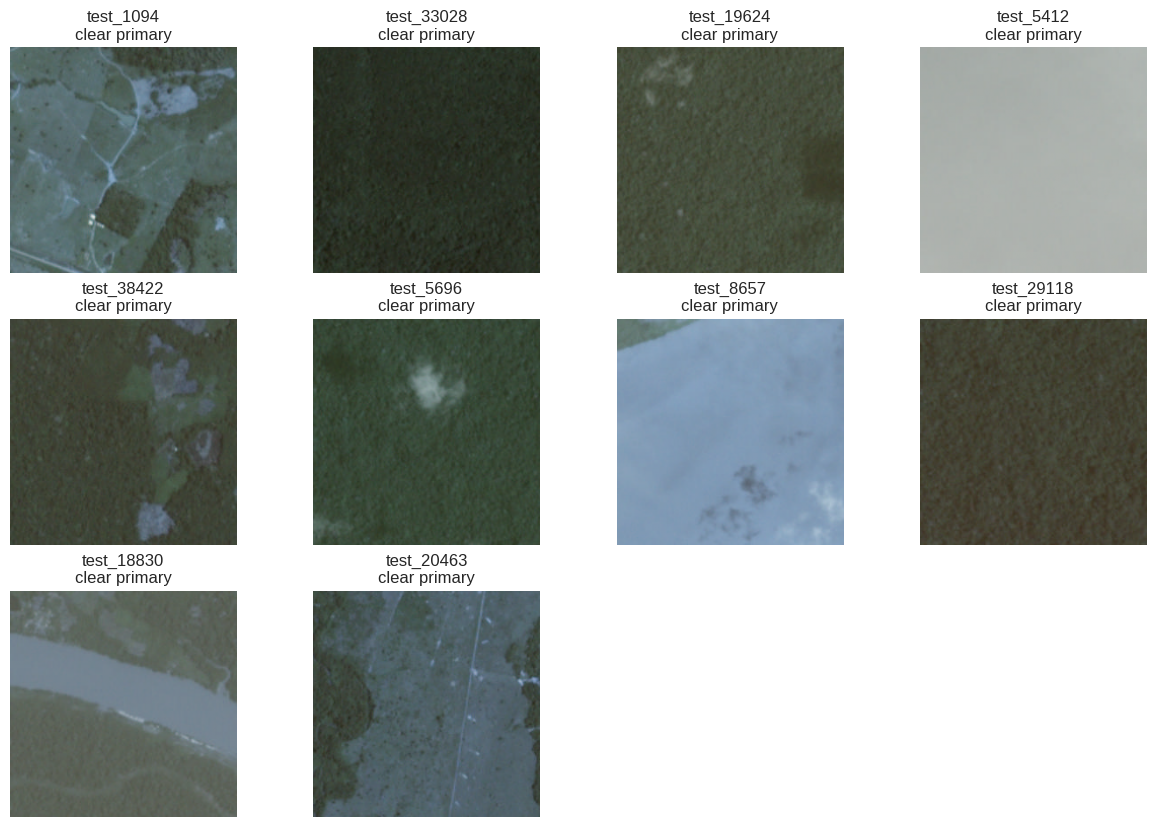

In [ ]:
#função para mostrar as imagens e suas previsões
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title(f'{loaded_image_names[i]}\n{" ".join(predicted_tags[i])}')
    plt.axis('off')
plt.show()

## Visualizando as Imagens por Tags

In [ ]:
df = pd.read_csv('/content/train_v2.csv/train_v2.csv')
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [ ]:
#separando as categorias
tags = df['tags'].apply(lambda x: x.split(' '))

#count das imagens
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


In [ ]:
#quantidade de imagens em cada tag
tags_contadas = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False).reset_index(drop=True)
tags_contadas.columns = ['tag', 'count']
tags_contadas

,tag,count
0,primary,37513
1,clear,28431
2,agriculture,12315
3,road,8071
4,water,7411
5,partly_cloudy,7261
6,cultivation,4547
7,habitation,3660
8,haze,2697
9,cloudy,2089


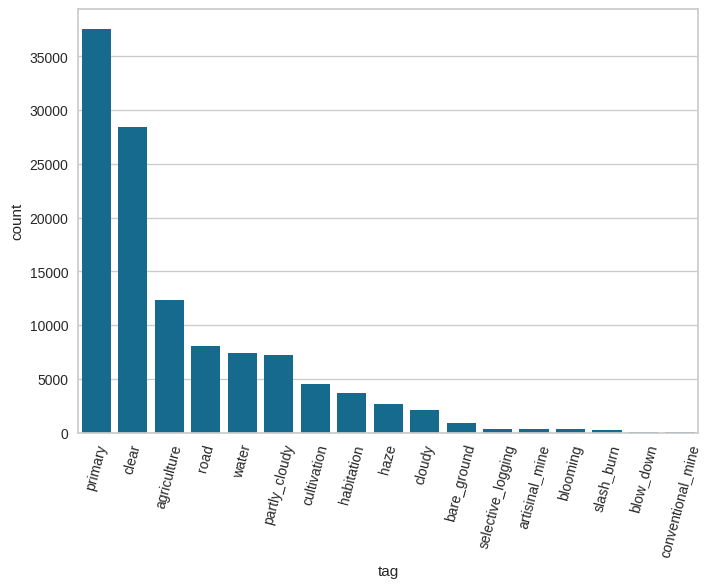

In [ ]:
#visualizando graficamente
sns.barplot(x='tag', y='count', data=tags_contadas)
plt.xticks(rotation=75)
plt.show()

In [ ]:
# !rm -r train-jpg-main

In [ ]:
#tags principais para o cálculo percentual de desmatamento
tags_desejadas = {"primary", "agriculture", "cultivation", "bare_ground", "slash_burn", "blooming", "blow_down"}

#filtrando, no df, as linhas apenas com essas tags
def possui_tags_desejadas(tags):
    return any(tag in tags_desejadas for tag in tags.split())

df_filtrado = df[df['tags'].apply(possui_tags_desejadas)]

print(f"Total de imagens no CSV: {len(df)}")
print(f"Total de imagens filtradas: {len(df_filtrado)}")
print("Primeiras linhas do DataFrame filtrado:")
print(df_filtrado.head())

#diretório de leitura e o que vai armazenar apenas as informações principais
imagem_dir = r'/content/train-jpg/train-jpg'
output_dir = r'/content/train-jpg-main'

#conferindo se a pasta nova existe
os.makedirs(output_dir, exist_ok=True)

#copiando as imagens do diretório original para o novo, com as imagens principais
for image_name in df_filtrado['image_name']:
    imagem_path = os.path.join(imagem_dir, f"{image_name}.jpg")
    if os.path.exists(imagem_path):
        shutil.copy(imagem_path, output_dir)
    else:
        print(f"Imagem {imagem_path} não encontrada")

print("Filtragem e cópia concluídas.")

Total de imagens no CSV: 40479
Total de imagens filtradas: 37995
Primeiras linhas do DataFrame filtrado:
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
Filtragem e cópia concluídas.


In [ ]:
# função para pegar as tags de cada imagem
def get_tags(img):
    tags = df_filtrado[df_filtrado['image_name'] == img]['tags'].values
    return tags[0]

In [ ]:
#carregar as imagens e mostrar
jpg_image_path = '/content/train-jpg-main/{}.jpg'

def get_image(name, form):
    if form == 'jpg':
        img = cv2.imread(jpg_image_path.format(name))
    else:
        print('Image format must be jpg')
    return img

def show_image(img, *caption):
    if img.shape == (256, 256, 3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        for caption in caption:
            plt.annotate(caption, xy=(3, 248), color='w')
    elif img.shape == (256, 256, 4):
        channels = cv2.split(img)
        f, ax = plt.subplots(1, 4, figsize=(18, 4))
        ax[0].imshow(channels[0], cmap='nipy_spectral')
        ax[1].imshow(channels[1], cmap='nipy_spectral')
        ax[2].imshow(channels[2], cmap='nipy_spectral')
        ax[3].imshow(channels[3], cmap='nipy_spectral')
        # Gerar legendas
        ax[0].set_title('Canal azul intensificado')
        ax[1].set_title('Canal verde intensificado')
        ax[2].set_title('Canal vermelho intensificado')
        ax[3].set_title('Canal infravermelho intensificado')
    else:
        print('Imagem inválida')
    plt.grid(False)
    plt.show()

train_24230


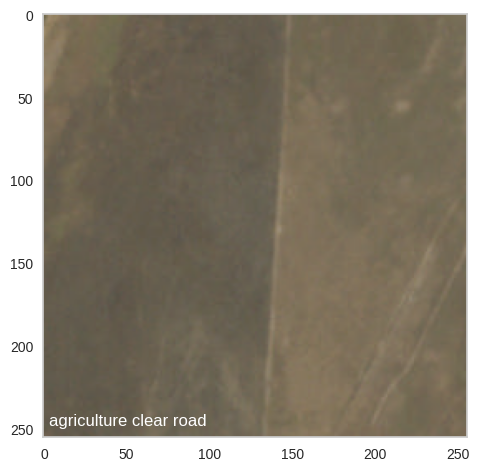

In [ ]:
#a cada vez que essa célula é rodada, uma nova imagem aleatória irá aparecer, com a sua respectiva tag
example_image_name = random.choice(df_filtrado['image_name'])
example_image = get_image(example_image_name, 'jpg')
print(example_image_name)
show_image(example_image, get_tags(example_image_name))

## Clustering para identificação de características da imagem

In [ ]:
#leitura da imagem
def imageAnalysis(number):
    img = imread('./train-jpg/train-jpg/train_{}.jpg'.format(number))
    img=cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB)
    X = img.reshape(-1,3)
    #regularização da imagem para obter 3 cores diferentes das imagens
    kmeans = KMeans(n_clusters=5).fit(X)
    img2 = kmeans.cluster_centers_[kmeans.labels_]
    img2 = img2.reshape(img.shape)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    #calcular a porcentagem de cada cor presente
    percent=[]
    for i in range(len(centroid)):
        j=labels.count(i)
        j=j/(len(labels))
        percent.append(j)
    print(df['tags'][number])
    fig = plt.figure()
    plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)),autopct='%.0f%%')
    plt.show()
    plt.imshow(img2.astype('uint8'))
    plt.grid(False)
    plt.show()

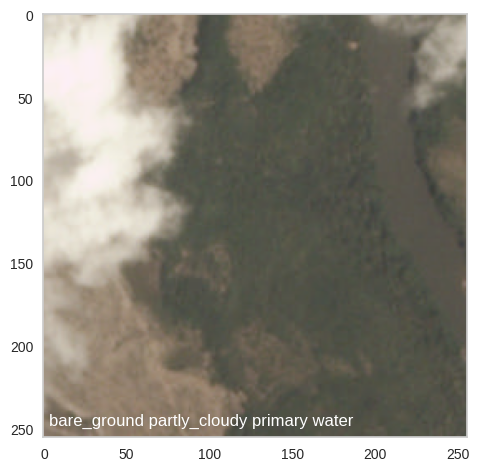

In [ ]:
#imagem train_22614
example_image_name = 'train_22614'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bare_ground partly_cloudy primary water


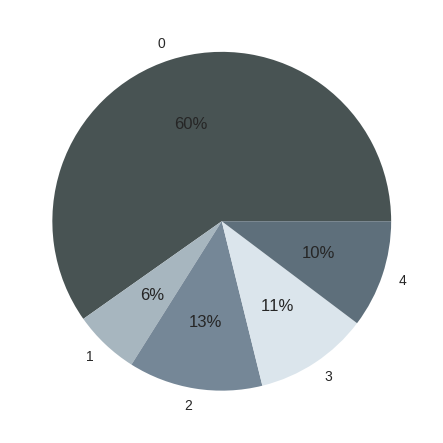

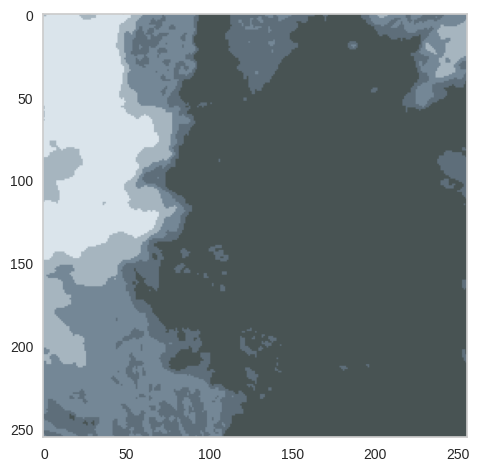

In [ ]:
imageAnalysis(22614)

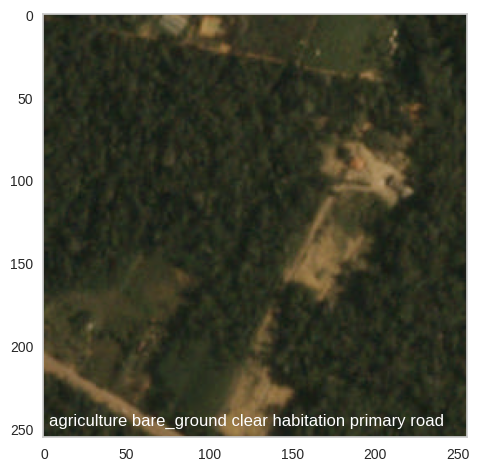

In [ ]:
#imagem train_123
example_image_name = 'train_123'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


agriculture bare_ground clear habitation primary road


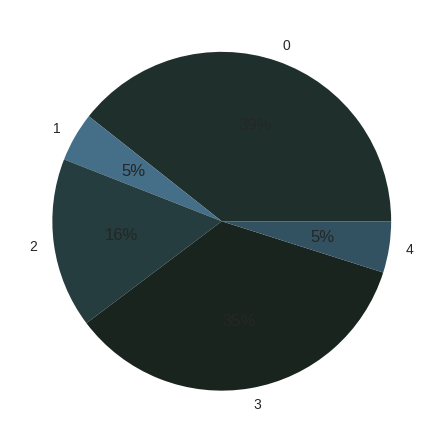

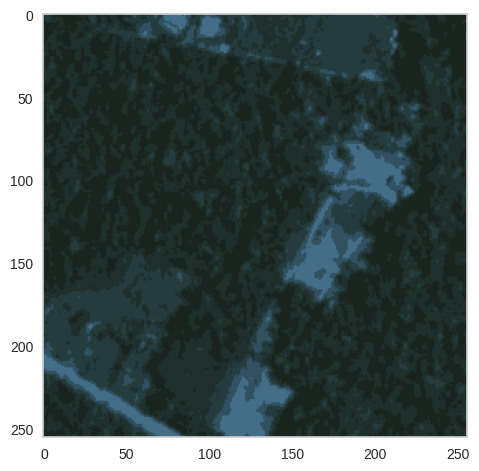

In [ ]:
imageAnalysis(123)

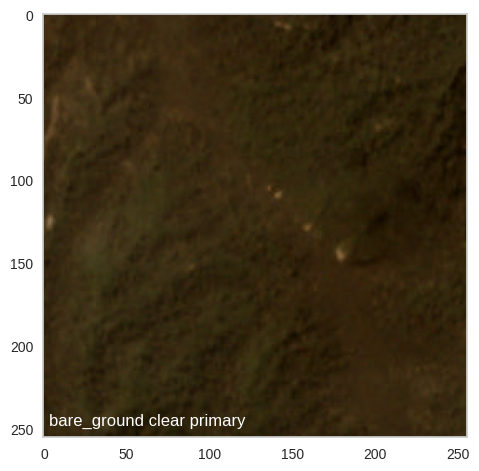

In [ ]:
#imagem train_124
example_image_name = 'train_124'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bare_ground clear primary


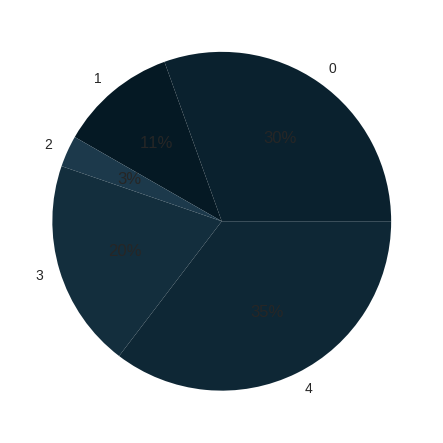

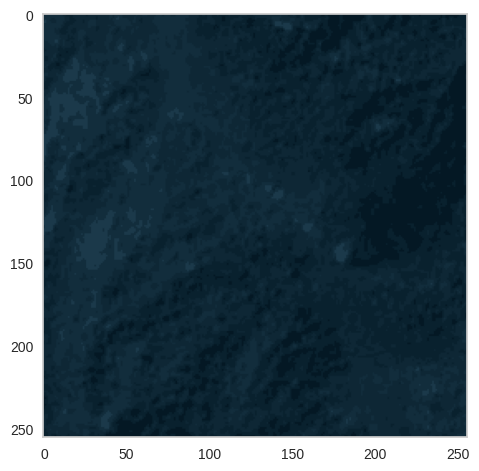

In [ ]:
imageAnalysis(124)

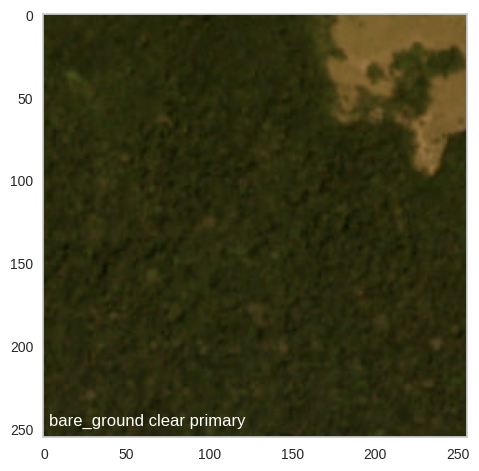

In [ ]:
#train_8789
example_image_name = 'train_8789'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bare_ground clear primary


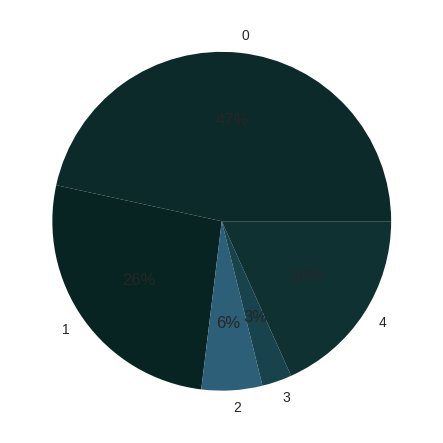

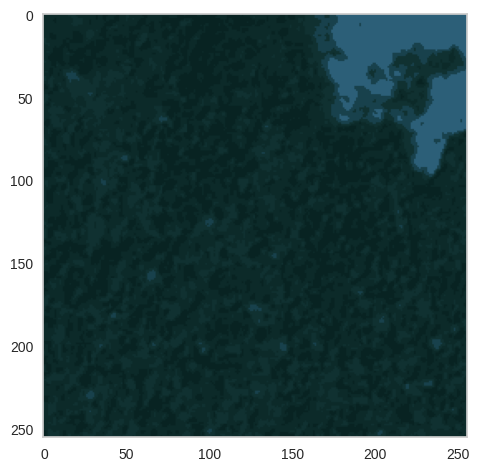

In [ ]:
imageAnalysis(8789)

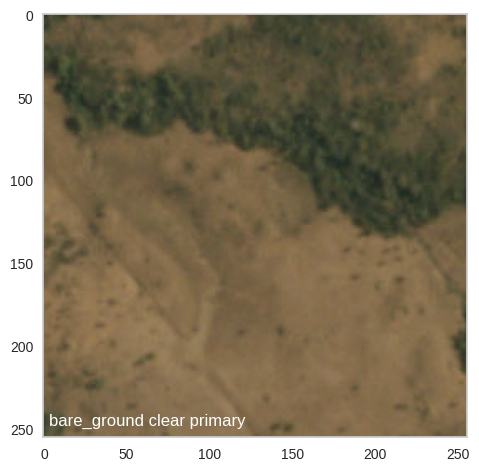

In [ ]:
#imagem train_8585
example_image_name = 'train_8585'
example_image = get_image(example_image_name, 'jpg')
show_image(example_image, get_tags(example_image_name))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


bare_ground clear primary


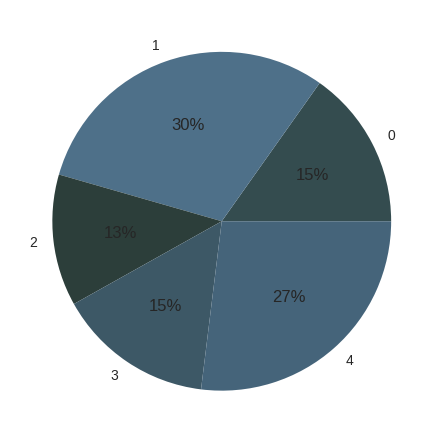

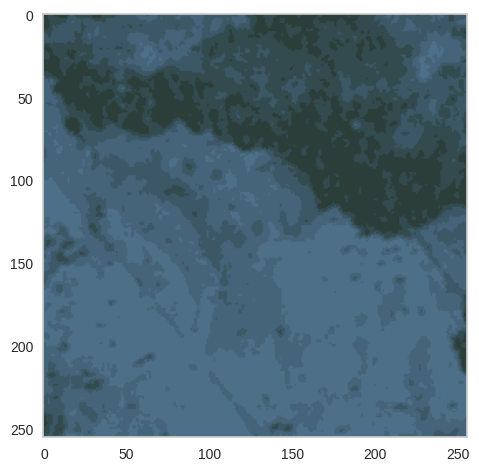

In [ ]:
imageAnalysis(8585)

# Testando com Clusters para Imagens Específicas

In [ ]:
# Quantas vezes a cor aparece
def centroid_histogram(cluster):
    # Obter o número de rótulos únicos nos clusters
    unique_labels = np.unique(cluster.labels_)
    num_labels = len(unique_labels)

    # Contar a ocorrência de cada rótulo nos clusters
    hist, _ = np.histogram(cluster.labels_, bins=num_labels)

    # Normalizar o histograma para que a soma seja 1
    hist = hist.astype("float") / hist.sum()

    return hist

In [ ]:
def plot_colors(hist, centroids):
    square_size = 50

    # Calcula o número de cores a partir dos centróides
    num_colors = len(centroids)

    bar_height = square_size
    bar_width = square_size * num_colors

    # Cria uma imagem preta
    bar = np.zeros((bar_height, bar_width, 3), dtype="uint8")

    # Itera sobre os centróides e desenha cada quadrado de cor na barra
    for i, color in enumerate(centroids):
        # Calcula o início e fim do quadrado na barra
        startX = i * square_size
        endX = startX + square_size
        cv2.rectangle(bar, (startX, 0), (endX, square_size),
                      color.astype("uint8").tolist(), -1)
    #Cria a barra de cores
    plt.figure(figsize=(num_colors, 1))
    plt.axis('off')
    plt.imshow(bar)
    plt.show()

In [ ]:
# Cores e os percentuais em um dataframe
def color_to_df(input, rgb1, rgb2, rgb3):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]

    #convert RGB to HEX code
    df_color_up = [rgb1, rgb2, rgb3]

    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df

In [ ]:
imgpath1 = './train-jpg/train-jpg/train_8789.jpg'

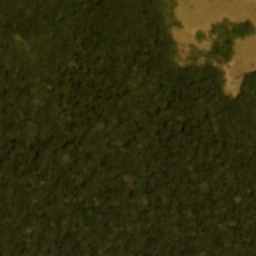

In [ ]:
Image(imgpath1)

In [ ]:
image = cv2.imread(imgpath1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((image.shape[0] * image.shape[1], 3))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

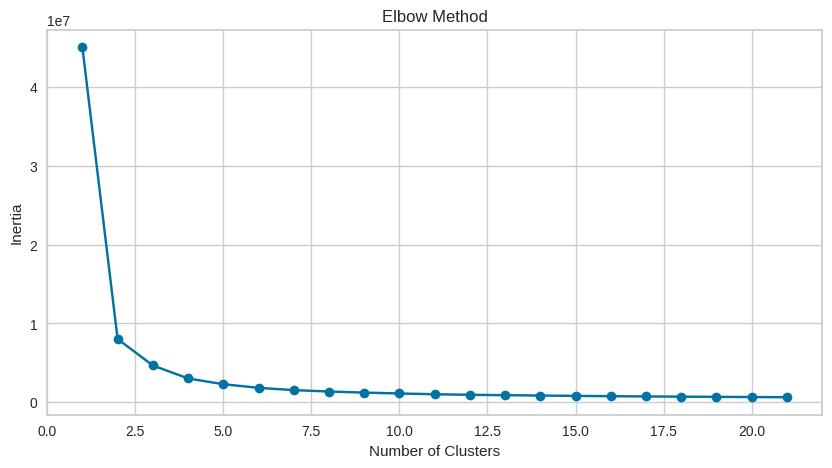

In [ ]:
# Método do Cotovelo para definir a qtd de clusters
inertia_values = []
for k in range(1, 22):
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42)
    kmeans.fit(image)
    inertia_values.append(kmeans.inertia_)
x = range(1, len(inertia_values) + 1)
plt.figure(figsize=(10, 5))
plt.plot(x, inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
elbow = plt.show()

In [ ]:
cluster = KMeans(n_clusters = 3)
cluster.fit(image)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

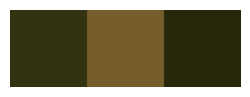

In [ ]:
# Principais cores presentes na imagem
hist = centroid_histogram(cluster)
bar = plot_colors(hist, cluster.cluster_centers_)
bar

In [ ]:
colors_x = extcolors.extract_from_path(imgpath1, tolerance = 12, limit = 12)
colors_x

([((40, 41, 12), 60060),
  ((123, 97, 45), 4064),
  ((67, 62, 21), 1356),
  ((20, 23, 3), 54),
  ((99, 75, 40), 2)],
 65536)

In [ ]:
# Cor e a frequência
df_color = color_to_df(colors_x, '#28290C', '#7B612D', '#433E15')
df_color = df_color.head(3)
df_color

,c_code,occurence
0,#28290C,60060
1,#7B612D,4064
2,#433E15,1356


In [ ]:
# Tags das cores
df = df_color.replace({'#28290C': 'Primary', '#7B612D': 'Bare Ground', '#433E15': 'Slash Burn'})

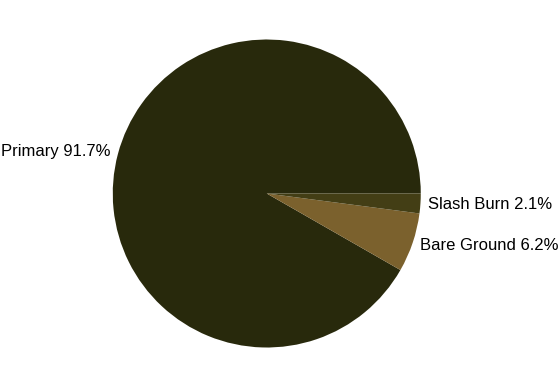

In [ ]:
# Gráfico de pizza com a frequência das tags, calculando o percentual de desmatamento
list_color = list(df_color['c_code'])
list_precent = [int(i) for i in list(df_color['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(df['c_code'],
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(50,50),dpi=10)
wedges, text = ax.pie(list_precent,
                      labels= text_c,
                      labeldistance= 1.05,
                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.show()

In [ ]:
imgpath2 = './train-jpg/train-jpg/train_8585.jpg'

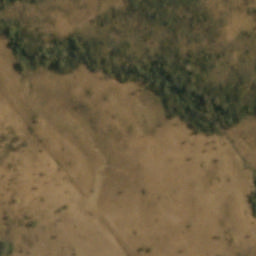

In [ ]:
Image(imgpath2)

In [ ]:
image = cv2.imread(imgpath2)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((image.shape[0] * image.shape[1], 3))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

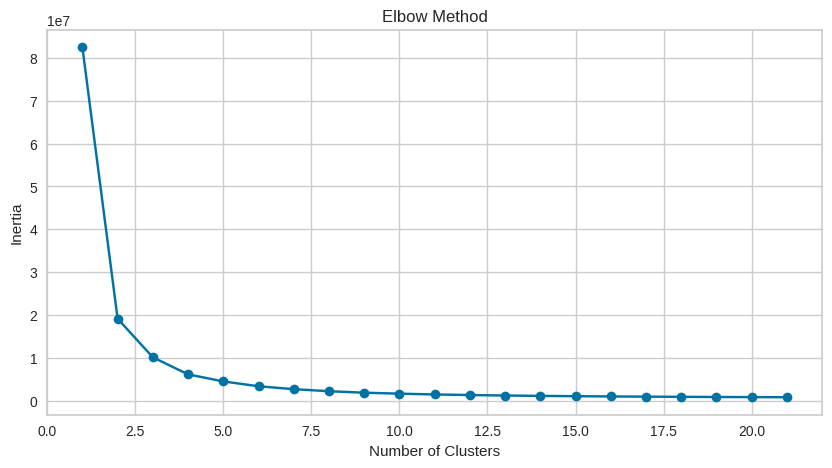

In [ ]:
inertia_values = []
for k in range(1, 22):
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42)
    kmeans.fit(image)
    inertia_values.append(kmeans.inertia_)
x = range(1, len(inertia_values) + 1)
plt.figure(figsize=(10, 5))
plt.plot(x, inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

elbow = plt.show()

In [ ]:
cluster = KMeans(n_clusters = 3)
cluster.fit(image)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

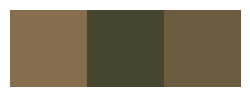

In [ ]:
hist = centroid_histogram(cluster)
bar = plot_colors(hist, cluster.cluster_centers_)
bar

In [ ]:
colors_x = extcolors.extract_from_path(imgpath2, tolerance = 12, limit = 12)
colors_x

([((135, 110, 76), 43059),
  ((71, 72, 49), 21922),
  ((44, 52, 41), 489),
  ((104, 85, 61), 66)],
 65536)

In [ ]:
df_color = color_to_df(colors_x, '#856d4c', '#6b5b3f', '#444530')
df_color = df_color.head(3)
df_color

,c_code,occurence
0,#856d4c,43059
1,#6b5b3f,21922
2,#444530,489


In [ ]:
df = df_color.replace({'#856d4c': 'Bare Ground', '#6b5b3f': 'Bare Ground', '#444530': 'Primary'})

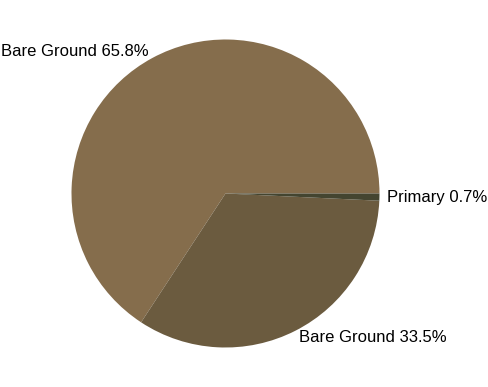

In [ ]:
list_color = list(df_color['c_code'])
list_precent = [int(i) for i in list(df_color['occurence'])]
text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(df['c_code'],
                                                                               list_precent)]
fig, ax = plt.subplots(figsize=(50,50),dpi=10)
wedges, text = ax.pie(list_precent,
                      labels= text_c,
                      labeldistance= 1.05,
                      colors = list_color,
                      textprops={'fontsize': 120, 'color':'black'}
                     )
plt.show()